#Simran Anand

## <b> Problem Description </b>

### This project aims to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then. Leveraging Natural Language Processing, sentiment analysis is to be done on the dataset. Additionally, machine learning algorithms are to be incorporated to evaluate accuracy score and classification prediction by the trained model.

### The following information is used:
1. Location
2. Tweet At
3. Original Tweet
4. Label

##Importing necessary libraries to build model

In [63]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import tweepy
from textblob import TextBlob
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import branca.colormap as cm
import requests
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap
import nltk # for text manipulation
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from wordcloud import WordCloud
from tqdm import tqdm, notebook
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

##Extracting dataset and Reviewing Our Dataset

In [4]:
df=pd.read_csv("https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv")
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [6]:
df.shape

(179108, 13)

In [7]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [8]:
# There are 12220 unique locations from where the tweets came.
df['user_location'].value_counts()

India                    3741
United States            2455
New Delhi, India         1721
Mumbai, India            1401
Washington, DC           1354
                         ... 
Yonkers NY                  1
near Palm Springs, CA       1
Parts down under            1
Mostly in the OC            1
Louvain, Belgium            1
Name: user_location, Length: 26920, dtype: int64

# Looking For Null Values

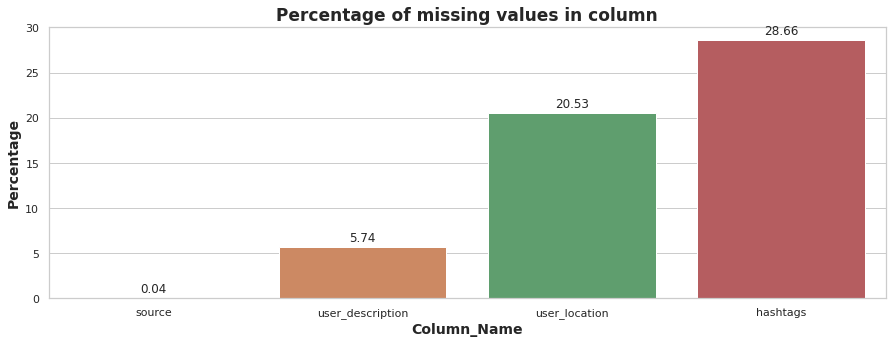

In [9]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

##Heat Map for missing values

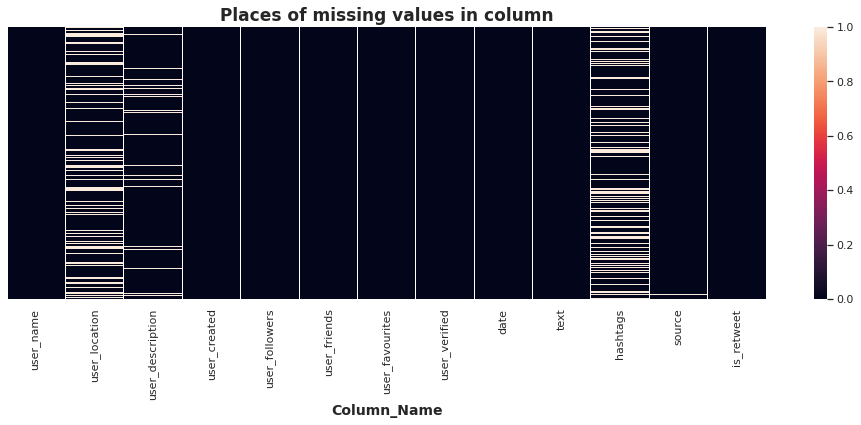

In [10]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

In [11]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


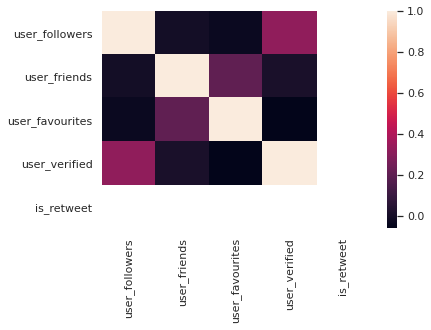

In [12]:
sns.heatmap(df.corr())

##Unique Values In Each Feature Coulmn

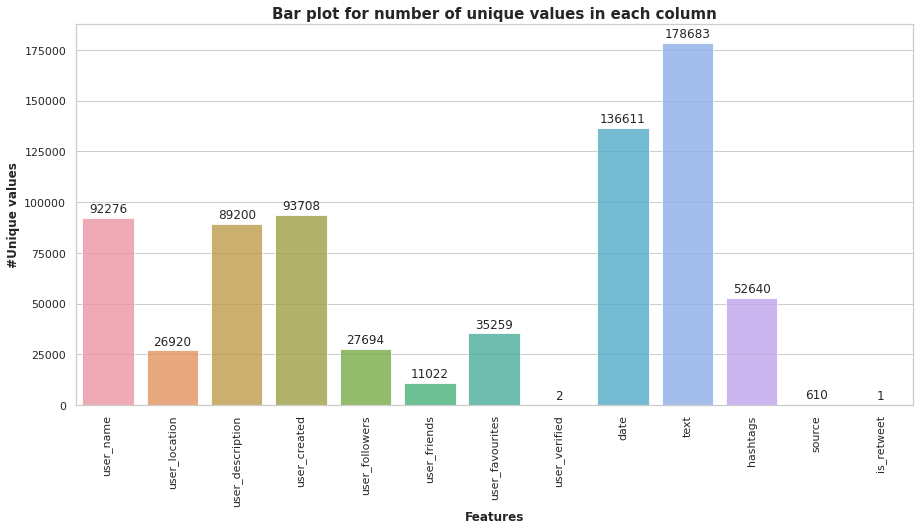

In [13]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

##Plot Of Top 15 Locations Of Tweet.

In [14]:
loc_analysis = pd.DataFrame(df['user_location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'user_location':'count'})

In [15]:
import plotly.graph_objects as go

In [16]:
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

##Detailed Analysis

In [17]:
# Make a copy of dataframe before making any changes
tweets = df.copy()

In [18]:
# Convert date columns to datetime data type from object
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['date_ext'] = tweets['date'].dt.date

In [19]:
# Take care of nulls in location and description
tweets.user_location.fillna('Unknown', inplace=True)
tweets.user_description.fillna('Unknown', inplace=True)
tweets.source.fillna('Unknown', inplace=True)
tweets.hashtags.fillna('None', inplace=True)

In [20]:
# Verify
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_name         179108 non-null  object        
 1   user_location     179108 non-null  object        
 2   user_description  179108 non-null  object        
 3   user_created      179108 non-null  datetime64[ns]
 4   user_followers    179108 non-null  int64         
 5   user_friends      179108 non-null  int64         
 6   user_favourites   179108 non-null  int64         
 7   user_verified     179108 non-null  bool          
 8   date              179108 non-null  datetime64[ns]
 9   text              179108 non-null  object        
 10  hashtags          179108 non-null  object        
 11  source            179108 non-null  object        
 12  is_retweet        179108 non-null  bool          
 13  date_ext          179108 non-null  object        
dtypes: b

#Data Preprocessing

**A) Removing @user**

In [21]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt
# create new column with removed @user
df['clean_text'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu


##REMOVED HTTP AND URLS FROM TWEET

In [22]:
import re
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that…"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A…
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,Trump never once claimed #COVID19 was a hoax. We all claim that this effort to…


##**B) Removing Punctuations, Numbers, and Special Characters**

In [23]:
# remove special characters, numbers, punctuations
df['clean_text'] = df['clean_text'].str.replace('[^a-zA-Z#]+',' ')

In [24]:
df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,If I smelled the scent of hand sanitizers today on someone in the past I would think they were so intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and wouldn t it have made more sense to have the players pay their respects to the A
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,Trump never once claimed #COVID was a hoax We all claim that this effort to
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False,The one gift #COVID has give me is an appreciation for the simple things that were always around me
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,July Media Bulletin on Novel #CoronaVirusUpdates #COVID


##**C) Removing Short Words**

In [25]:
# remove short words
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


##**D) Tokenization**

In [26]:
# create new variable tokenized tweet 
tokenized_tweet = df['clean_text'].apply(lambda x: x.split())
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


##**E) Stemming**

In [27]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


In [28]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['clean_text'] to tokenized_tweet

In [29]:
df['clean_text']  = tokenized_tweet
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smell the scent hand sanit today someon the past would think they were intox that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,hey and wouldn have made more sens have the player pay their respect the


##Story Generation and Visualization from Tweets

#What are the most common words in the entire dataset?

*  What are the most common words in the dataset for negative and positive tweets, respectively?

*  How many hashtags are there in a tweet?

*  Which trends are associated with my dataset?

*  Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

**Understanding the common words used in the tweets: WordCloud**

In [30]:
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smell the scent hand sanit today someon the past would think they were intox that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,hey and wouldn have made more sens have the player pay their respect the


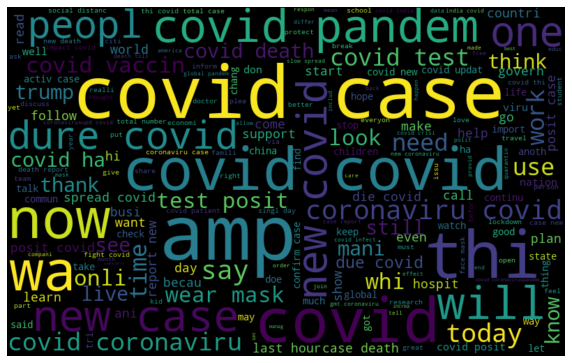

In [31]:
# create text from all tweets
all_words = ' '.join([text for text in df['clean_text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#**Extracting Features from Cleaned Tweets**
###Removing Stopwords

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [34]:
df['clean_text'].apply(lambda x: [item for item in x if item not in stop])

0                           [e, l, l,  , h, e,  , c, e, n,  , h, n,  , n,  ,  , e, n,  , h, e,  , p,  , w, u, l,  , h, n, k,  , h, e,  , w, e, r, e,  , n, x,  , h]
1                  [h, e,  , n,  , w, u, l, n,  , h, v, e,  , e,  , r, e,  , e, n,  , h, v, e,  , h, e,  , p, l, e, r,  , p,  , h, e, r,  , r, e, p, e, c,  , h, e]
2                                             [r, u, p,  , n, e, v, e, r,  , n, c,  , c, l,  , #, c, v,  , w,  , h, x,  , l, l,  , c, l,  , h,  , h,  , e, f, f, r]
3         [h, e,  , n, e,  , g, f,  , #, c, v,  , h,  , g, v, e,  , p, p, r, e, c,  , f, r,  , h, e,  , p, l,  , h, n, g,  , h,  , w, e, r, e,  , l, w,  , r, u, n]
4                                                                     [j, u, l,  , e,  , b, u, l, l, e, n,  , n, v, e, l,  , #, c, r, n, v, r, u, u, p,  , #, c, v]
                                                                                    ...                                                                            
179103          

In [35]:
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smell the scent hand sanit today someon the past would think they were intox that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,hey and wouldn have made more sens have the player pay their respect the


##Check and calculate sentiment of tweets

In [36]:
#creates a function that determines subjectivity and polarity from the textblob package
def getTextSubjectivity(clean_text):
    return TextBlob(clean_text).sentiment.subjectivity
def getTextPolarity(clean_text):
    return TextBlob(clean_text).sentiment.polarity
#applies these functions to the dataframe
df['Subjectivity'] = df['clean_text'].apply(getTextSubjectivity)
df['Polarity'] = df['clean_text'].apply(getTextPolarity)
#builds a function to calculate and categorize each tweet as Negative, Neutral, and Positive
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
#creates another column called Score and applies the function to the dataframe
df['Score'] = df['Polarity'].apply(getTextAnalysis)

34.40717332559126 % of positive tweets
51.3701230542466 % of neutral tweets
14.222703620162136 % of negative tweets


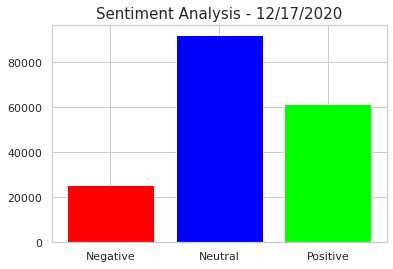

In [37]:
#visualizes the data through a bar chart
labels = df.groupby('Score').count().index.values
values = df.groupby('Score').size().values
plt.bar(labels, values, color = ['red', 'blue', 'lime'])
plt.title(label = "Sentiment Analysis - 12/17/2020", 
                  fontsize = '15')
#calculates percentage of positive, negative, and neutral tweets
positive = df[df['Score'] == 'Positive']
print(str(positive.shape[0]/(df.shape[0])*100) + " % of positive tweets")
positive = df[df['Score'] == 'Neutral']
print(str(positive.shape[0]/(df.shape[0])*100) + " % of neutral tweets")
positive = df[df['Score'] == 'Negative']
print(str(positive.shape[0]/(df.shape[0])*100) + " % of negative tweets")

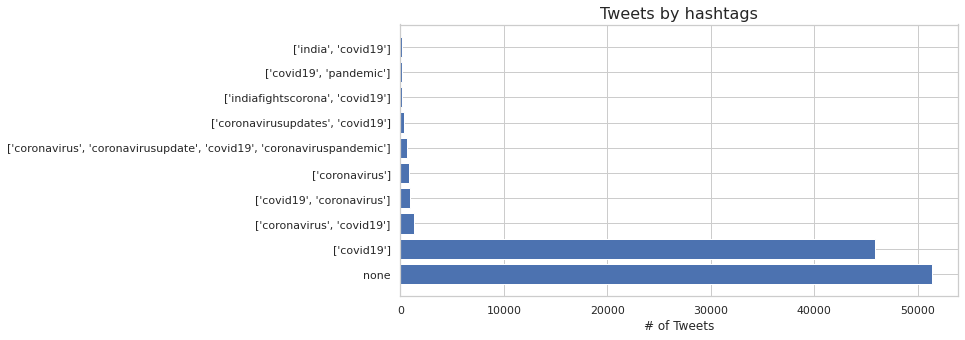

In [54]:
# Most trended hashtags
top10_hashtags = tweets.hashtags.str.lower().value_counts().nlargest(10)
# initiate the figure with it's size
fig = plt.figure(figsize = (10,5))
plt.barh(top10_hashtags.index, top10_hashtags.values)
plt.xlabel('# of Tweets')
plt.title("Tweets by hashtags", fontsize=16);

In [66]:
# We are using Compound score to detect the tweet sentiment which is a metric that calculates the sum of
# all the lexicon ratings which have been normalized between 
# -1(most extreme negative) and +1 (most extreme positive)
# positive: (compound score >= 0.05), negative : (compound score <= -0.05), neutral otherwise
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for index, row in tqdm(tweets.iterrows()): #tqdm 
    ss = sid.polarity_scores(row['text'])
    if ss['compound'] >= 0.05 : 
        tweets.at[index,'sentiment'] = "Positive"
    elif ss['compound'] <= - 0.05 : 
        tweets.at[index,'sentiment'] = "Negative"
    else : 
        tweets.at[index,'sentiment'] = "Neutral"


     |████████████████████████████████| 133kB 5.4MB/s 


179108it [00:54, 3272.95it/s]


#Tweets Sentiments Distribution plotted graphically after leveraging NLP

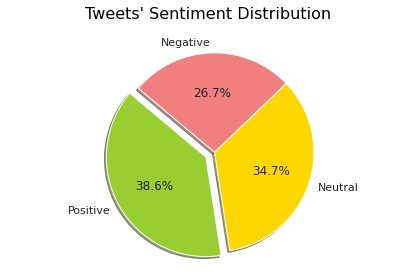

In [67]:
# Show distribution of tweet sentiments
sentiment_dist = tweets.sentiment.value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode= (0.1,0,0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets\' Sentiment Distribution \n", fontsize=16, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [68]:
# Function to filter top 10 tweets by sentiment
def top10AccountsBySentiment(sentiment):
    df = tweets.query("sentiment==@sentiment")
    top10 = df.groupby(by=["user_name"])['sentiment'].count().sort_values(ascending=False)[:10]
    return(top10)

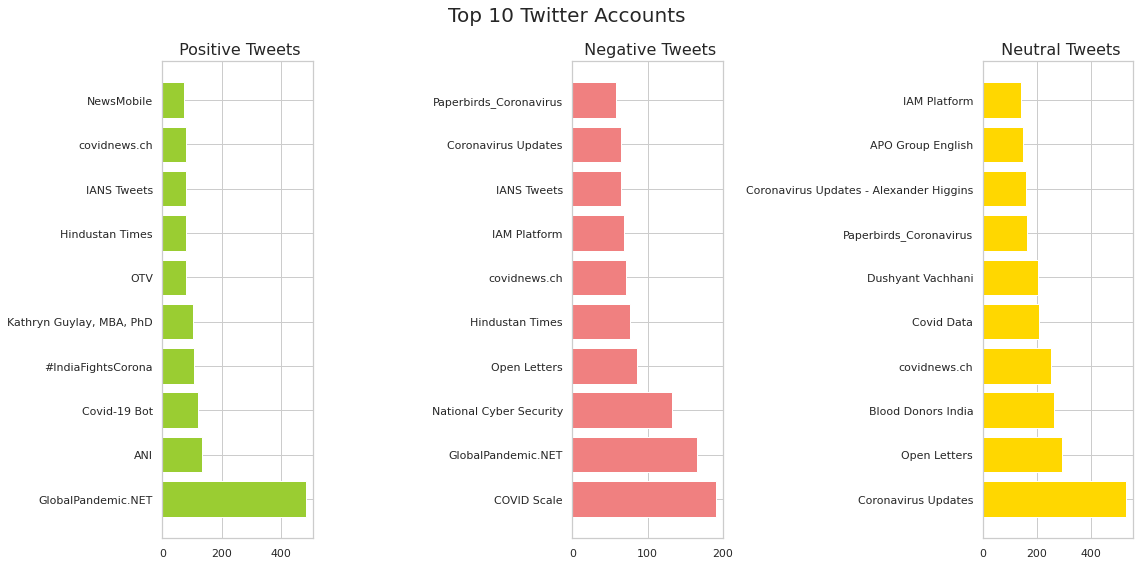

In [69]:
# Top 10 tweets by each sentiment
top10_pos = top10AccountsBySentiment("Positive")
top10_neg = top10AccountsBySentiment("Negative")
top10_neu = top10AccountsBySentiment("Neutral")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, figsize=(16,8))
fig.suptitle('Top 10 Twitter Accounts \n', fontsize=20)

ax1.barh(top10_pos.index, top10_pos.values, color='yellowgreen')
ax1.set_title("\n\n Positive Tweets", fontsize=16)

ax2.barh(top10_neg.index, top10_neg.values, color='lightcoral')
ax2.set_title("\n\n Negative Tweets", fontsize=16)

ax3.barh(top10_neu.index, top10_neu.values, color='gold')
ax3.set_title("\n\n Neutral Tweets", fontsize=16);

fig.tight_layout()
fig.show()

In [70]:
df.head(1)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text,Subjectivity,Polarity,Score
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smell the scent hand sanit today someon the past would think they were intox that,0.25,-0.25,Negative


In [71]:
new_df=df[['clean_text','Score']]

##Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [72]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Score.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (143286, 2)
valid shape :  (35822, 2)


# Use Of Counter Vectorizer For Multi Class Classification

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (143286, 60177)
X_train.shape :  (35822, 60177)
y_train.shape :  (143286,)
y_valid.shape :  (35822,)


## Naive Bayes Classifier for MULTICLASS Classification

In [74]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.9004787627542119
Validation accuracy Score :  0.8631288035285579
              precision    recall  f1-score   support

    Negative       0.64      0.82      0.71      3964
     Neutral       0.92      0.91      0.91     18586
    Positive       0.88      0.82      0.85     13272

    accuracy                           0.86     35822
   macro avg       0.81      0.85      0.82     35822
weighted avg       0.87      0.86      0.87     35822



#*Thank you! :)*